#### Uncertainty of convective precipitation retrievals from Ka-band space-borne radar observations

Mircea Grecu and John Yorks

**Issues**

* Severe attenuation, signal loss in the bottom portion of the profiles
* Retrievals depend on the *"a priori"* assumptions
* The objective function associated with the retrieval problem is highly non-linear and difficult to optimize.  Gauss-Newton may not converge or converge to a local minimum.  Global optimization approaches exist, but they are usually time-consuming.
* Initial solution is very important.

**Methodology**

* Generate potential solutions based on the *"a priori"* distributions.
* Use nearest neighbor procedure to find the closest $N$ matches.
* Refine estimates using ensemble smoother.
$X=X+cov(X,Y)(cov(Y,Y)+R)^{-1}(Y_{obs}-Y)$

**Sensitivity analysis**

* Cluster the profiles into 9 classes and use the class-mean precipitation profiles instead of the overall mean to generate solutions.
* Investigate performance by class.


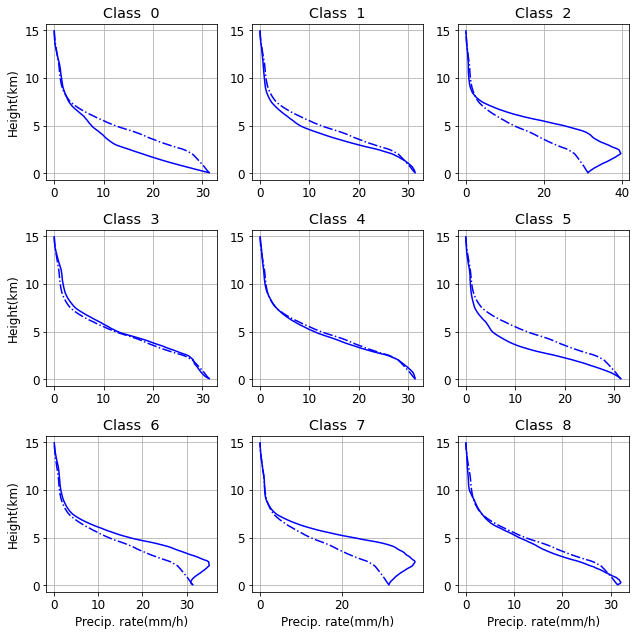

In [16]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib

fh=Dataset("simulatedObs_SAM_compressed.nc")

from sklearn.cluster import KMeans

zKa=fh["zKa_obs"][:]
zKa_true=fh["zKa_true"][:]
attKa=fh["attKa"][:]
tbL=fh["tb35"][:]
#xL=fh["xL"][:]
piaKa=fh["piaKa"][:]
zKa0=zKa
zKa0[zKa0<0]=0
pRate=fh["pRate"][:]
fh.close()

a=np.nonzero(zKa_true[:,50]>0)
pZ_snow=np.polyfit(np.log(pRate[a[0],50]),zKa_true[a[0],50],1)
att_snow=np.polyfit(np.log(pRate[a[0],50]),np.log(attKa[a[0],50]),1)
pZ_rain=np.polyfit(np.log(pRate[a[0],0]),zKa_true[a[0],0],1)
att_rain=np.polyfit(np.log(pRate[a[0],0]),np.log(attKa[a[0],0]),1)
h=125/2.+np.arange(150)*125

fint=np.interp(range(150),[0,35,40,150],[1,1,0,0])
zL=[]
dr=0.125
for i,pRate1 in enumerate(pRate[:,:]):
    snowRate=(1-fint)*pRate1
    zSnow=pZ_snow[0]*np.log(snowRate+1e-3)+pZ_snow[1]
    attSnow=np.exp(att_snow[0]*np.log(snowRate+1e-3)+att_snow[1])
    rainRate=fint*pRate1
    zRain=pZ_rain[0]*np.log(rainRate+1e-3)+pZ_rain[1]
    zTot=10*np.log10(10**(0.1*zSnow)+10**(0.1*zRain))
    attRain=np.exp(att_rain[0]*np.log(rainRate+1e-3)+att_rain[1])
    attTot=(attSnow+attRain)*2*dr
    pia=attTot[::-1].cumsum()[::-1]
    zTot-=pia
    zL.append(zTot)

zL=np.array(zL)
from sklearn.model_selection import train_test_split

ind=range(zKa.shape[0])
ind_train, ind_test, \
    y_train, y_test \
    = train_test_split(ind, pRate[:,0], \
                       test_size=0.25, random_state=42)

from sklearn.cluster import KMeans
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

kmeans = KMeans(n_clusters=9, random_state=0).fit(pRate[ind_train,:120])
plt.figure(figsize=(9,9))
pRateM=[]
pRatem=pRate[ind_train,:120].mean(axis=0)
for i in range(9):
    a=np.nonzero(kmeans.labels_==i)
    plt.subplot(3,3,i+1)
    p1=pRate[ind_train,:120][a[0],:].mean(axis=0)
    pRateM.append(p1*pRatem[0]/p1[0])
    plt.plot(p1*pRatem[0]/p1[0],h[:120]/1000.,\
             color='blue')
    plt.plot(pRatem,h[:120]/1000.,'-.',color='blue')
    if i%3==0:
        plt.ylabel('Height(km)')
    if i>=6:
        plt.xlabel('Precip. rate(mm/h)')
    plt.grid()
    plt.title('Class %2i'%i)
    plt.tight_layout()
    
plt.savefig('avegProfiles_2.png')

In [12]:
import xarray as xr
zKaX=xr.DataArray(zKa)
zKa_trueX=xr.DataArray(zKa_true)
attKaX=xr.DataArray(attKa)
tbLX=xr.DataArray(tbL)
piaKaX=xr.DataArray(piaKa)
pRateX=xr.DataArray(pRate)
ds=xr.Dataset({"zKa_obs":zKaX,"zKa_true":zKa_trueX,"tb35":tbLX,"piaKa":piaKaX,"attKa":attKaX,"pRate":pRateX})
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in ds.data_vars}
ds.to_netcdf("simulatedObs_SAM_compressed.nc", encoding=encoding)

In [17]:
covT=np.cov(zL[ind_train,:120].T,pRate[ind_train,:120].T)
covYY_inv=np.linalg.pinv(covT[:120,:120]+np.eye(120)*9)
kGain=covT[120:,:120]@covYY_inv
pRatem=pRate[ind_train,:120].mean(axis=0)

zthr=10
zL0=zL.copy()
zL0[zL0<zthr]=0
neigh.fit(zL0[ind_train,:120])
x1,x2,x3=[],[],[]
ind_train=np.array(ind_train)
rng = np.random.default_rng()
import combAlg as calg
import scipy
import scipy.optimize
from scipy.optimize import minimize as minimize

B_inv=np.linalg.pinv(covT[120:,120:])
def pinverse(pRate):
    u,s,vt=np.linalg.svd(pRate,full_matrices=False)
    nc=40
    u1=u[:,:nc]
    vt1=vt[:nc,:]
    inv1=np.diag(1/s[:nc])
    pinv=vt1.T@inv1@u1.T
    bapp=u1@np.diag(s[:nc])@vt1
    return pinv,bapp

def f_obj(x):
    pRateEns1=x
    z_att_f = calg.computez(pRateEns1,fint[:120],\
                            pZ_snow,pZ_rain,att_snow,att_rain,dr)
    z_att_f[z_att_f<zthr]=0
    f_val1=1/2*(z_att_f-zobs0).T@(z_att_f-zobs0)/4
    f_val2=1/2*(x-pRatem).T@B_inv@(x-pRatem)
    return float(f_val1),float(f_val2)

In [20]:
neigh = NearestNeighbors(n_neighbors=150)
zthr=10
nEns=10000
xsc=np.diag([1.3 for i in range(120)])
classes=[0,1,2,3,4,5,6,7,8]
xc=[]
fll=[]
def computeZ(pRate,fint,pZ_snow,pZ_rain,att_snow,att_rain):
    zL=[]
    for i, pRate1 in enumerate(pRate[:,:]):
        snowRate=(1-fint)*pRate1
        zSnow=pZ_snow[0]*np.log(snowRate+1e-3)+pZ_snow[1]
        attSnow=np.exp(att_snow[0]*np.log(snowRate+1e-3)+att_snow[1])
        rainRate=fint*pRate1
        zRain=pZ_rain[0]*np.log(rainRate+1e-3)+pZ_rain[1]
        zTot=10*np.log10(10**(0.1*zSnow)+10**(0.1*zRain))
        attRain=np.exp(att_rain[0]*np.log(rainRate+1e-3)+att_rain[1])
        attTot=(attSnow+attRain)*2*dr
        pia=attTot[::-1].cumsum()[::-1]
        zTot-=pia
        zL.append(zTot)
    return np.array(zL)
for c in classes:
    pRateEns = rng.multivariate_normal(pRateM[c], covT[120:,120:]@xsc, (nEns))
    pRateEns[pRateEns<0]=0
    zEns=computeZ(pRateEns[:,:120],fint[:120],pZ_snow,pZ_rain,\
                  att_snow,att_rain)
    zEns[zEns<zthr]=0
    neigh.fit(zEns)
    x1=[]
    x2=[]
    x3=[]
    FL=[]
    for i in ind_test:
        a0=np.nonzero(zL[i,:120]>10)
        zobs=zL[i,:120]
        zobs0=zobs.copy()
        zobs0[zobs0<zthr]=0
        ind=neigh.kneighbors([zobs0])
        ind=ind[-1][0]
        x1.append(pRateEns[ind,0:120].mean(axis=0))
        x2.append(pRate[i,0:120])
        pRateEns_1=pRateEns[ind,:120].copy()
        for it in range(2):
            zEns_1=computeZ(pRateEns_1,fint[:120],pZ_snow,pZ_rain,\
                        att_snow,att_rain)
        zEns_1[zEns_1<zthr]=0
        covT_ens=np.cov(zEns_1.T,pRateEns_1.T)
        covYY_inv=np.linalg.pinv(covT_ens[:120,:120]+np.eye(120)*4*2)
        kGainE=covT_ens[120:,:120]@covYY_inv
        for ie in range(150):
            pRateEns_1[ie,:]=pRateEns_1[ie,:]+\
                kGainE[:,a0[0]]@(zL[i,a0[0]]-zEns_1[ie,:][a0])
        pRateEns_1[pRateEns_1<0]=0
        pRateEns1=pRateEns_1.mean(axis=0)
        x3.append(pRateEns1[0:120])
        FL.append([f_obj(x1[-1]),f_obj(x2[-1]),f_obj(x3[-1])])
        xc.append([x1,x2,x3])
    print(FL[-1])
    fll.append([FL])

[(204.05641373785699, 2.284650364789344), (13.449145938127733, 29.120709050766237), (88.27223766061314, 5.966093332308352)]
[(291.5950721501061, 1.6871816782950262), (13.449145938127733, 29.120709050766237), (119.61300965276753, 6.80808433000484)]
[(315.3360718368794, 2.0097031363524502), (13.449145938127733, 29.120709050766237), (226.81355107394518, 5.0459446233161795)]
[(238.1780930734829, 1.6702474688654103), (13.449145938127733, 29.120709050766237), (119.84923253903094, 5.187049638071814)]
[(265.0272914026064, 1.66920563221883), (13.449145938127733, 29.120709050766237), (146.49600670954302, 5.330382504377443)]
[(275.5597861524503, 2.302950627858676), (13.449145938127733, 29.120709050766237), (98.62163628386975, 7.299030646322384)]
[(291.50117321327014, 1.5549228413130258), (13.449145938127733, 29.120709050766237), (196.32285261517507, 5.0576560168910305)]
[(367.5118433307696, 1.679265846776735), (13.449145938127733, 29.120709050766237), (297.9720774992203, 5.5954359465950105)]
[(23

In [ ]:
xc=np.array(xc)
import pickle
pickle.dump([xc,np.array(fll)],open("enKF_stats.pklz","wb"))

In [2]:
import pickle
xc,fll=pickle.load(open("enKF_stats.pklz","rb"))
print(xc.shape)

(9, 3, 698, 120)


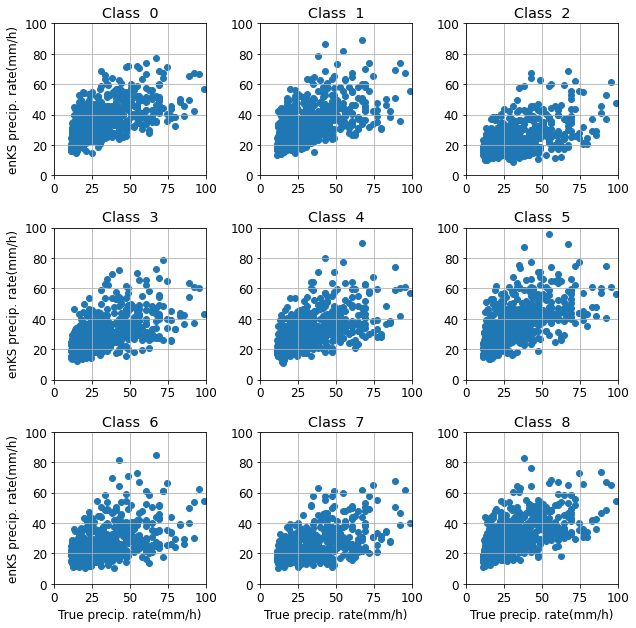

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,9))
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    ax.set_aspect('equal')
    plt.scatter(xc[i,1,:,0],xc[i,2,:,0])
    if i%3==0:
        plt.ylabel('enKS precip. rate(mm/h)')
    if i>=6:
        plt.xlabel('True precip. rate(mm/h)')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.grid()
    plt.title('Class %2i'%i)
    #print(np.corrcoef(xc[i,1,:,0],xc[i,2,:,0]))
    plt.tight_layout()

plt.savefig('scatterPlot.png')


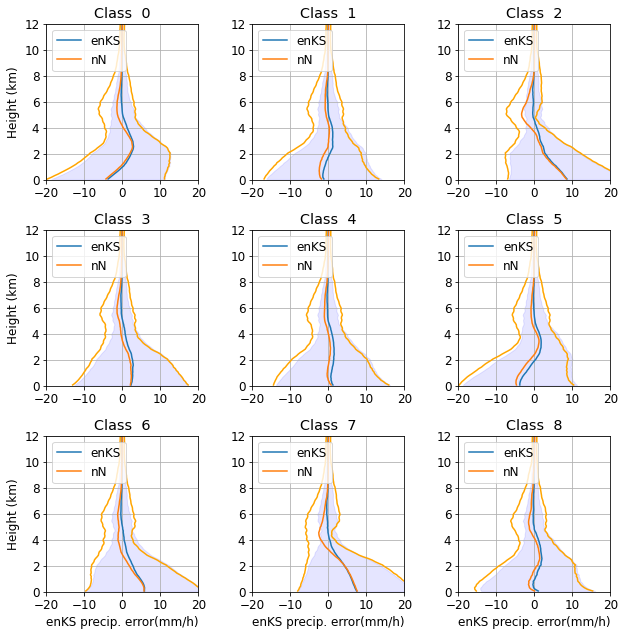

In [33]:
plt.figure(figsize=(9,9))
h=125/2.+np.arange(150)*125
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    #ax.set_aspect('equal')
    plt.plot((xc[i,1,:,:]-xc[i,2,:,:]).mean(axis=0),h[:120]/1000.0)
    plt.plot((xc[i,1,:,:]-xc[i,0,:,:]).mean(axis=0),h[:120]/1000.0)
    x1s=(xc[i,1,:,:]-xc[i,2,:,:]).std(axis=0)
    x1m=(xc[i,1,:,:]-xc[i,2,:,:]).mean(axis=0)
    plt.fill_betweenx(h[:120]/1e3,x1m-x1s,x1m+x1s,color='blue',alpha=0.1)
    x1s=(xc[i,1,:,:]-xc[i,0,:,:]).std(axis=0)
    x1m=(xc[i,1,:,:]-xc[i,0,:,:]).mean(axis=0)
    #plt.fill_betweenx(h[:120]/1e3,x1m-x1s,x1m+x1s,color='orange',alpha=0.1)
    plt.plot(x1m-x1s,h[:120]/1e3,color='orange')
    plt.plot(x1m+x1s,h[:120]/1e3,color='orange')
    if i%3==0:
        plt.ylabel('Height (km)')
    if i>=6:
        plt.xlabel('enKS precip. error(mm/h)')
    plt.grid()
    plt.xlim(-20,20)
    plt.ylim(0,14)
    plt.legend(['enKS','nN'],loc=2)
    plt.title('Class %2i'%i)
    #print(np.corrcoef(xc[i,1,:,0],xc[i,2,:,0]))
plt.tight_layout()
plt.savefig('retUncertain.png')

In [20]:
a=np.nonzero(xc!=xc)
print(len(a[0]))

0
